In [2]:
from escher import Builder
from IPython.display import display
import cobra
import pandas as pd
from cobra.io import read_sbml_model, write_sbml_model, save_json_model, load_json_model
import numpy as np
from matplotlib import pyplot as plt

In [3]:
import gurobipy
from optlang.gurobi_interface import Model, Variable, Constraint, Objective
import cobra.test
#model.Model()

In [ ]:
save_json_model(model, '/Users/hellpark/Desktop/Bioinformatics/model_objects/Chalmers_halov2.json')
write_sbml_model(model, '/Users/hellpark/Desktop/Bioinformatics/model_objects/Chalmers_halov2.sbml')

In [13]:
model = read_sbml_model('/Users/hellpark/Desktop/Bioinformatics/model_objects/Chalmers_halov2.sbml')

## Gene KO by varying yeast and glucose
https://github.com/SysBioChalmers/Halo-GEM/blob/master/ComplementaryScripts/Curations/Scripts/model_status_and_gene_essentiality.ipynb

In [283]:
model2=read_sbml_model('/Users/hellpark/Desktop/Bioinformatics/model_objects/HalomonasCOBRAModelv2.sbml')

In [ ]:
model.medium
set_yeast_extraction(model)

set_yeast_extraction(model)

In [5]:
def set_yeast_extraction(model,ub=1000,lb=-1000):
    # given the evidence that TD01 strain can growth wihout supplyment of amino acids, 
    # the strain should be able to produce 20 amino acids by itself.
    # Block the uptake of 20 amino acids
    amino_acids = ['CYS_c','L-ASPARTATE_c','GLT_c','PHE_c','GLY_c',
                  'HIS_c','ILE_c','LYS_c','LEU_c','MET_c','ASN_c',
                  'PRO_c','GLN_c','ARG_c','SER_c','THR_c','VAL_c',
                  'TRP_c','L-ALPHA-ALANINE_c','TYR_c','L-LACTATE','CPD-15990', 'ADENINE','AMMONIA'
                   
                  ]
    for met_id in amino_acids:
        exg_rxn = model.reactions.get_by_id('Exchange_'+met_id.replace('_c',''))
        exg_rxn.upper_bound = ub
        exg_rxn.lower_bound = lb
        
        
def set_yeast_extraction2(model,ub=1000,lb=-1000):
    # given the evidence that TD01 strain can growth wihout supplyment of amino acids, 
    # the strain should be able to produce 20 amino acids by itself.
    # Block the uptake of 20 amino acids
    amino_acids = ['CYS_c','L-ASPARTATE_c','GLT_c','PHE_c','GLY_c',
                  'HIS_c','ILE_c','LYS_c','LEU_c','MET_c','ASN_c',
                  'PRO_c','GLN_c','ARG_c','SER_c','THR_c','VAL_c',
                  'TRP_c','L-ALPHA-ALANINE_c','TYR_c','L-LACTATE','CPD-15990', 'ADENINE']
    for met_id in amino_acids:
        exg_rxn = model.reactions.get_by_id('Exchange_'+met_id.replace('_c',''))
        exg_rxn.upper_bound = ub
        exg_rxn.lower_bound = lb
def test_biomass_production(model,show=False):
    with model:
        set_yeast_extraction2(model,lb=0,ub=0)
        model.objective = 'Biomass_v1'
        model.objective_direction = 'max'
        s1 = model.optimize()
        if show:print('Without YE:',s1)

    with model:
        set_yeast_extraction2(model,lb=0,ub=1000)
        model.objective = 'Biomass_v1'
        model.objective_direction = 'max'
        s2 = model.optimize()
        if show:print('With unlimited YE:',s2)
    
    if not show:return s1,s2
def test_glucose(model):
    with model:
        rgs = []
        glcs = np.arange(0,120,10)
        for glc in glcs:
            set_bound(model,'Exchange_Glucopyranose',ub=glc)
            s1,s2 = test_biomass_production(model,show=False)
            rgs.append([s1.objective_value,s2.objective_value])

        plt.figure(figsize=(7,3))
        rgs = np.array(rgs)
        titles = ['Without YE','With YE']
        for i in range(2):
            plt.subplot(1,2,i+1)
            #plt.scatter(glcs,rgs[:,0],label='Without YE')
            plt.scatter(glcs,rgs[:,i])
            plt.ylabel('Specific growth rate (h$^{-1}$)')
            plt.xlabel('Glucose uptake (mmol/dDW/h)')
            plt.title(titles[i])

        plt.tight_layout()
        plt.show()

def set_bound(model,rxn_id,lb=None,ub=None,eq=None):
    rxn = model.reactions.get_by_id(rxn_id)
    if lb is not None: rxn.lower_bound = lb
    if ub is not None: rxn.upper_bound = ub
    if eq is not None: 
        rxn.lower_bound = eq
        rxn.upper_bound = eq

def test_met_production(model,met_id,show=True):
    with model:
        sink = cobra.Reaction('tmp_sink')
        sink.add_metabolites({model.metabolites.get_by_id(met_id):-1})
        model.add_reactions([sink])
        model.objective = 'tmp_sink'
        s = model.optimize()
        if show:
            print(s)
    return s

def change_rxn_coeff(rxn,met,new_coeff):
    '''
    # This is based on the rxn.add_metabolites function. If there the metabolite is already in the reaction,
    # new and old coefficients will be added. For example, if the old coeff of metA is 1, use
    # rxn.add_metabolites({metA:2}), After adding, the coeff of metA is 1+2 = 3
    #
    '''

    diff_coeff = new_coeff-rxn.metabolites[met]
    rxn.add_metabolites({met:diff_coeff})

def test_oxygen_to_ATP(model):
    with model:
        rgs = []
        glcs = np.arange(0,100)
        for glc in glcs:
            set_bound(model,'Exchange_OXYGEN-MOLECULE',ub=glc)
            s1,s2 = test_atp_production(model)
            rgs.append([s1.objective_value,s2.objective_value])

        plt.figure(figsize=(7,3))
        rgs = np.array(rgs)
        titles = ['Without YE','With YE']
        for i in range(2):
            plt.subplot(1,2,i+1)
            #plt.scatter(glcs,rgs[:,0],label='Without YE')
            plt.scatter(glcs,rgs[:,i])
            plt.title(titles[i])
            plt.ylabel('ATP_c (mmol/dDW/h)')
            plt.xlabel('Glucose uptake (mmol/dDW/h)')

        plt.tight_layout()
        plt.show()
def test_atp_production(model):
    atp_sink = cobra.Reaction('atp_sink')
    atp_sink.add_metabolites({model.metabolites.ATP_c:-1})
    
    with model:
        model.add_reactions([atp_sink])
        set_yeast_extraction(model,lb=0,ub=0)
        model.objective = 'atp_sink'
        model.objective_direction = 'max'
        s1 = model.optimize()

    with model:
        model.add_reactions([atp_sink])
        set_yeast_extraction(model,lb=0,ub=1000)
        model.objective = 'atp_sink'
        model.objective_direction = 'max'
        s2 = model.optimize()
    return s1,s2

In [ ]:
model.add_cons_vars(same_flux)

In [ ]:
model.reactions.Exchange_Glucopyranose.upper_bound=100
model.reactions.Exchange_AMMONIA.upper_bound = 20

In [6]:
def test_PHA_production(model):
    pha_sink = cobra.Reaction('pha_sink')
    pha_sink.add_metabolites({model.metabolites.get_by_id('PHA_c'):-1})
    
    with model:
        model.add_reactions([pha_sink]) 
        set_yeast_extraction(model,lb=0,ub=1)
        model.objective = 'pha_sink'
        model.objective_direction = 'max'
        s1 = model.optimize()

    return s1

def test_urea_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,16,1)
        set_bound(model,'Exchange_Glucopyranose',ub=20)
        for glc in glcs:
            set_bound(model,'Exchange_UREA',ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1',lb=s1.objective_value,ub=s1.objective_value)
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value*240/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots()
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, linestyle='dashed')
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='orange', linestyle='solid')
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=18)
        ax2.set_ylabel('PHA (g/(gDW*h))',size=18)
        ax1.set_xlabel('Urea (mmol/(gDW*h)',size=18)
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA%'], bbox_to_anchor=(0.6, .92),frameon='False')


        fig.tight_layout()
        plt.show()

def test_phosphate_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,3,.1)
        set_bound(model,'Exchange_Glucopyranose',ub=20)
        for glc in glcs:
            set_bound(model,'Exchange_CPD-16459',lb=glc,ub=glc)
            #set_bound(model,'Exchange_K+',lb=glc)
            set_yeast_extraction(model,lb=0,ub=1)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1')
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value*240/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

            
        fig, ax1 = plt.subplots()
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, linestyle='dashed')
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='orange', linestyle='solid')
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=18)
        ax2.set_ylabel('PHA (g/(gDW*h))',size=18)
        ax1.set_xlabel('Phosphate (mmol/(gDW*h)',size=18)
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA%'], bbox_to_anchor=(0.6, .92),frameon='False')
   
        fig.tight_layout()
        plt.show()

def test_sulfate_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,1,.1)
        set_bound(model,'Exchange_Glucopyranose',ub=200)
        for glc in glcs:
            set_bound(model,'Exchange_MG+2',ub=glc)
            set_bound(model,'Exchange_HSO4',lb=glc,ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1')
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value*240/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots()
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, linestyle='dashed')
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='orange', linestyle='solid')
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=18)
        ax2.set_ylabel('PHA (g/(gDW*h))',size=18)
        ax1.set_xlabel('MgSO\u2084 (mmol/(gDW*h)',size=18)
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA%'], bbox_to_anchor=(0.6, .92),frameon='False')
   
        fig.tight_layout()
        plt.show()
        
def test_o_2(model):
    with model:
        rgs = []
        rgs2 = []
        glcs = np.arange(0,50,.5)
        set_bound(model,'Exchange_Glucopyranose',ub=100)
        for glc in glcs:
            set_bound(model,'Exchange_OXYGEN-MOLECULE',lb=glc,ub=glc)
            set_yeast_extraction(model,lb=0,ub=0)
            s1 = model.optimize()
            rgs.append(s1.objective_value)
            
            set_bound(model,'Biomass_v1')
            s3 = test_PHA_production(model)
            rgs2.append(s3.objective_value*86/10000)
            set_bound(model,'Biomass_v1',lb=0,ub=1000)

        fig, ax1 = plt.subplots()
        rgs = np.array(rgs)
        ax1.plot(glcs, rgs, linestyle='dashed')
        ax2 = ax1.twinx()
        ax2.plot(glcs, rgs2, color='orange', linestyle='solid')
        ax1.set_ylabel('Specific growth rate (h$^{-1}$)', size=18)
        ax2.set_ylabel('PHA (g/(gDW*h))',size=18)
        ax1.set_xlabel('O\u2082 (mmol/(gDW*h)',size=18)
     #   ax2.set_ylim([0,1])
        fig.legend([rgs, rgs2], labels=['Cell Growth','PHA%'], bbox_to_anchor=(0.6, .42),frameon='False')
   
        fig.tight_layout()
        plt.show()

/Users/hellpark/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


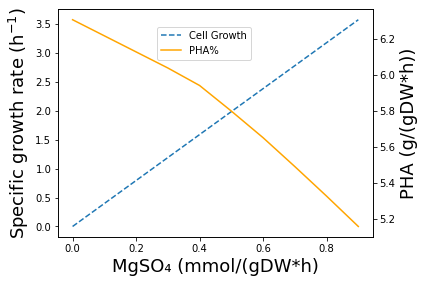

In [475]:
#test_phosphate_2(model)
#test_urea_2(model)
test_sulfate_2(model)
#test_o_2(model)

In [286]:
from cobra.flux_analysis import flux_variability_analysis

In [287]:
result = flux_variability_analysis(model)
result

,minimum,maximum
RXN-6021,0.000000,1.000000e+03
DEOXYRIBOSE-P-ALD-RXN,36.397556,3.639756e+01
ABC-3-RXN,8.606653,8.606653e+00
ABC-4-RXN,0.000000,0.000000e+00
ABC-14-RXN,2.376064,2.376064e+00
...,...,...
DM_OROTATE_c,0.000000,0.000000e+00
PHA_synthetase,0.000000,-8.164136e-12
PHA_secretion,0.000000,-3.410605e-12
NGAM,6.860000,6.860000e+00


In [7]:
from cobra.flux_analysis import production_envelope
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as tri

In [43]:
set_bound(model, 'Exchange_UREA',ub=20,lb=-20)
set_yeast_extraction(model,ub=2,lb=0)

In [48]:
model.reactions.get_by_id('Exchange_OXYGEN-MOLECULE').lower_bound=1
model.reactions.get_by_id('Exchange_OXYGEN-MOLECULE').upper_bound=20
model.reactions.get_by_id('Exchange_Glucopyranose').lower_bound=1
model.reactions.get_by_id('Exchange_Glucopyranose').upper_bound=50

In [10]:
newobjective=model.problem.Objective(
    0.5*model.reactions.Biomass_v1.flux_expression + 0.5*model.reactions.PHA_secretion.flux_expression)
newconstraint = model.problem.Constraint(0.5*model.reactions.Biomass_v1.flux_expression - 0.5*model.reactions.PHA_secretion.flux_expression,
                                        lb=0, ub=0)
model.add_cons_vars(newconstraint)

In [11]:
prod_env = production_envelope(model, ['Exchange_Glucopyranose','Exchange_OXYGEN-MOLECULE'],objective='PHA_secretion')
prod_env

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,Exchange_Glucopyranose,Exchange_OXYGEN-MOLECULE
0,,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,0.000000
1,,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.052632
2,,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.105263
3,,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.157895
4,,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.210526
...,...,...,...,...,...,...,...,...,...
395,,0.0,NaN,NaN,0.856078,NaN,NaN,50.0,15.789474
396,,0.0,NaN,NaN,0.968997,NaN,NaN,50.0,16.842105
397,,0.0,NaN,NaN,1.081916,NaN,NaN,50.0,17.894737
398,,0.0,NaN,NaN,1.194834,NaN,NaN,50.0,18.947368


In [73]:
def o2_glucose_impact(model,a,swapped=True):
    
    newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - (1-a)*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0)
        
    with model:
        model.add_cons_vars(newconstraint)
        prod_env = production_envelope(model, ['Exchange_Glucopyranose','Exchange_OXYGEN-MOLECULE'],objective='PHA_secretion')

        fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
        # Make data.
        if swapped:
            X = prod_env['Exchange_OXYGEN-MOLECULE']
            Y = prod_env['Exchange_Glucopyranose']
        else:
            Y = prod_env['Exchange_OXYGEN-MOLECULE']
            X = prod_env['Exchange_Glucopyranose']
        Zmask = np.isfinite(prod_env['flux_maximum'])
        Z = prod_env['flux_maximum']

        # Plot the surface.
        surf = ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.rainbow,
                                antialiased=False,linewidth=0,vmin=0,vmax=max(prod_env['flux_maximum']))
        # Customize the axis.
        ax.set_zlim(0, max(prod_env['flux_maximum']))
        if swapped:
            ax.set_xlabel('$O\u2082 (mmol/(gDW*h))$', fontsize=16, rotation=150)
            ax.set_ylabel('$Glucose (mmol/(gDW*h)$',fontsize=16)
        else:
            ax.set_xlabel('$Glucose (mmol/(gDW*h)$', fontsize=16, rotation=150)
            ax.set_ylabel('$O\u2082 (mmol/(gDW*h))$',fontsize=16)
        ax.set_zlabel('$Flux (mmol/(gDW*h)$', fontsize=16, rotation=60)
        ax.zaxis.set_major_formatter('{x:.1f}')
        #ax.set_xlim(xmin=1)

        ax.set_facecolor('white') 
        ax.grid(False) 


        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=.5, aspect=10,orientation='horizontal')
        plt.title('Constraint: '+str(a)+'*Biomass+'+str(((1-a)))+'*PHA\nObjective=Maximize PHA',fontsize=20)

        plt.show()

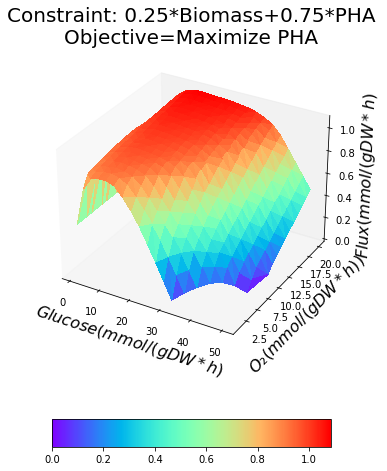

In [69]:
o2_glucose_impact(model,0.25,False)

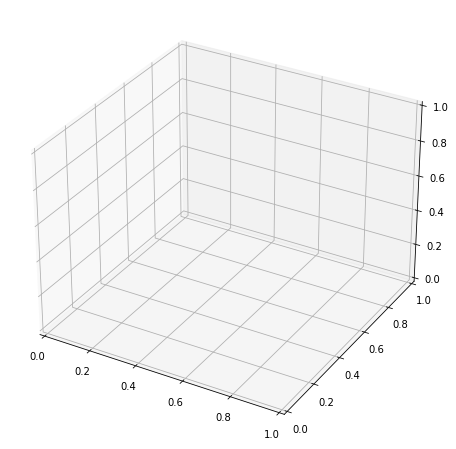

In [74]:
import matplotlib.animation as animation
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))

In [ ]:
newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - b*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0)
        
    with model:
        model.add_cons_vars(newconstraint)
        prod_env = production_envelope(model, ['Exchange_Glucopyranose','Exchange_OXYGEN-MOLECULE'],objective='PHA_secretion')
        
def 

def animate(a):
    newconstraint = model.problem.Constraint(
        a*model.reactions.Biomass_v1.flux_expression - (1-a)*model.reactions.PHA_secretion.flux_expression,
        lb=0, ub=0)
    X = prod_env['Exchange_OXYGEN-MOLECULE']
    Y = prod_env['Exchange_Glucopyranose']
    Zmask = np.isfinite(prod_env['flux_maximum'])
    Z = prod_env['flux_maximum']
    ax.plot_trisurf(X[Zmask], Y[Zmask], Z[Zmask], cmap=cm.rainbow,
                    antialiased=False,linewidth=0,vmin=0,vmax=max(prod_env['flux_maximum']))
    return ax
    
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,

In [82]:
model.metabolites.PHA_c.formula_weight

259.0

In [ ]:
ecoli = read_sbml_model('/Users/hellpark/Downloads/iJO1366 (1).xml')

In [ ]:
quadratic_objective = model.problem.Objective(
    model.reactions.PHA_synthetase.flux_expression+model.reactions.Biomass_v1.flux_expression,
    direction='max')
model.objective = quadratic_objective
#solution = model.optimize(objective_sense=None)

In [ ]:
PHAMW=(model.metabolites.get_by_id('CPD-650_c').formula_weight-model.metabolites.get_by_id('CO-A_c').formula_weight)/model.metabolites.get_by_id('CPD-650_c').formula_weight
CellMW=265

In [13]:
from cobra import Model, Reaction, Metabolite
import numpy as np

'''
Section 1: Operate the model
'''

def updateKcats(ecmodel,kcats):
    # kcats: dict() {(rxn_id, prot_met_id): kcat in h-1}
    for (rxn_id, prot_met_id),kcat in kcats.items():
        rxn = ecmodel.reactions.get_by_id(rxn_id)
        prot_met = ecmodel.metabolites.get_by_id(prot_met_id)
        
        new_coeff = -1./kcat
        
        change_rxn_coeff(rxn,prot_met,new_coeff)
        

def parse_gr_rule(gr):
    '''
    Parse gr rule into a list of components. 
    gr: gene reaction rule, defined in cobrapy.
    
    For example: 
    
    Input         : Output
    A or B        : ["A", "B"]
    (A and B)     : ["A and B"]
    (A and B) or C: ["A and B","C"]
    
    Usage: complexes = parse_gr_rule(gr)
    
    Gang Li, last updated 2020-03-04
    
    '''
    complexes = [item.strip().replace('(','').replace(')','') for item in gr.split('or')]
    if len(complexes) < 2 and len(complexes[0]) < 1: complexes = []
    
    return complexes

def constrainAbandance(model,measured):
    '''
    model       : eModel from convertToEnzymeModel()
    measured    : a dictionary with measured enzyme abandance, in the unit of mmol/gdw
    
    # define the upper bound of protein exchange reactions with protein abandance.
    # e.g. the reaction id is in the format of "prot_TD01GL001367_exchange"
    
    Usage: model = constrainAbandance(model,MWs, non_measured,UB)
    '''

    for prot_id, ab in measured.items():
        rxn_id = 'prot_{0}_exchange'.format(prot_id)
        model.reactions.get_by_id(rxn_id).upper_bound = ab
   
    return model

def constrainPool(model,MWs, measured, non_measured,UB,copy=True):
    '''
    model       : eModel from convertToEnzymeModel()
    MWs         : a dictionary with molecular weight of enzymes, in the unit of kDa
    non_measured: a list of enzymes without proteomics data
    measured    : a dictionary with measured enzyme abandance, in the unit of mmol/gdw
    UB          : upper bound for the combined pool of those non_measured enzymes
    copy        : if creat a copy of the original model
    
    Define new rxns: For each enzyme, add a new rxn that draws enzyme from the
    enzyme pool (a new metabolite), and remove previous exchange rxn. The new
    rxns have the following stoichiometry (T is the enzyme pool):
     MW[i]*P[T] -> P[i]
     
    Usage: model = constrainPool(model,MWs, non_measured,UB)
    
    Gang Li, last updated 2020-03-04
    '''
    if copy: model = model.copy()
    # create prot_pool metabolite 
    prot_pool = Metabolite('prot_pool')
    prot_pool.name = prot_pool.id
    
    rxns_to_add  = list()
    rxns_to_drop = list()
    for prot in non_measured:
        prot_exchange_rxn = model.reactions.get_by_id('prot_{0}_exchange'.format(prot))
        
        draw_rxn = Reaction('draw_prot_{0}'.format(prot))
        draw_rxn.name = draw_rxn.id
        draw_rxn.add_metabolites({prot_pool:-MWs[prot],list(prot_exchange_rxn.metabolites)[0]:1})
        
        rxns_to_add.append(draw_rxn)
        rxns_to_drop.append(prot_exchange_rxn)
        
    # add draw reaction into model
    model.add_reactions(rxns_to_add)
    model.remove_reactions(rxns_to_drop)
    
    # change the upper bound for all reactions as np.inf
    for rxn in model.reactions: rxn.upper_bound = np.inf
    
    # add prot_pool_exchange rxn
    rxn_prot_pool_exg = Reaction('prot_pool_exchange')
    rxn_prot_pool_exg.name = rxn_prot_pool_exg.id
    rxn_prot_pool_exg.add_metabolites({prot_pool:1})
    rxn_prot_pool_exg.lower_bound = 0
    rxn_prot_pool_exg.upper_bound = UB
    
    model.add_reaction(rxn_prot_pool_exg)
    
    # constrain the proteins with measure abandance
    constrainAbandance(model,measured)
    
    return model
        
def constrainPools(model,MWs, dfgo, Ptot, condition_id, sigma=0.5,copy=True):
    '''
    Add multiple sub-pools. Each pool for a unique set of genes.
    
    model       : eModel from convertToEnzymeModel()
    MWs         : a dictionary with molecular weight of enzymes, in the unit of kDa
    dfgo        : a pd.DataFrame() with GoSlim ids as index and with at least two columns: 'Genes' and 'MassFrac'
    condition_id: condition id
    Ptot        : total protein abandance, in the unit of g/gDW
    copy        : if creat a copy of the original model
    
    Define new rxns: For each enzyme, add a new rxn that draws enzyme from the
    enzyme pool (a new metabolite), and remove previous exchange rxn. The new
    rxns have the following stoichiometry (T is the enzyme pool):
     MW[i]*P[T] -> P[i]
     
    Usage: model = constrainPool(model,MWs, non_measured,UB)
    
    Gang Li, last updated 2020-09-07
    '''
    if copy: model = model.copy()
    
    rxns_to_add  = list()
    rxns_to_drop = list()
    exg_rxns_to_add = list()
    for go in dfgo.index:
        # create prot_pool metabolite 
        goid = go.replace(':','')
        prot_pool = Metabolite('prot_pool_{0}'.format(goid))
        prot_pool.name = prot_pool.id
    
        for i,prot in enumerate(dfgo.loc[go,'Genes'].split(';')):
            prot_exchange_rxn = model.reactions.get_by_id('prot_{0}_exchange'.format(prot))

            draw_rxn = Reaction('draw_prot_{0}_{1}'.format(prot,goid))
            draw_rxn.name = draw_rxn.id
            draw_rxn.add_metabolites({prot_pool:-MWs[prot],list(prot_exchange_rxn.metabolites)[0]:1})

            rxns_to_add.append(draw_rxn)
            rxns_to_drop.append(prot_exchange_rxn)
        
        # add prot_pool_exchange rxn
        rxn_prot_pool_exg = Reaction('prot_pool_exchange_{0}'.format(goid))
        rxn_prot_pool_exg.name = rxn_prot_pool_exg.id
        rxn_prot_pool_exg.add_metabolites({prot_pool:1})
        rxn_prot_pool_exg.lower_bound = 0
        rxn_prot_pool_exg.upper_bound = dfgo.loc[go,'MassFrac_{0}'.format(condition_id)]*Ptot*sigma
        exg_rxns_to_add.append(rxn_prot_pool_exg)
        
    # add reactions into model
    model.add_reactions(list(set(rxns_to_add)))
    model.remove_reactions(list(set(rxns_to_drop)))
    
    # change the upper bound for all reactions as np.inf
    for rxn in model.reactions: rxn.upper_bound = np.inf
    
    model.add_reactions(exg_rxns_to_add)
    
    return model 


def convertToEnzymeModel(model,kcats):
    '''
    model .   : irrevModel
    kcats     : a dictionary with kcat values {('protein_id',rxn_id):100,...}
    
    Usage: eModel = convertToEnzymeModel(model,kcats)
    
    Gang Li, last updated 2020-03-04
    '''
    converted_reaction_list = []
    protein_exchange_rxns = {}
    for rxn in model.reactions:
        complexes = parse_gr_rule(rxn.gene_reaction_rule)
        
        # 1. for those reactions without genes 
        if len(complexes) <1: 
            converted_reaction_list.append(rxn)
            continue
        
        # 2. for those reactions with genes, but no kcat
        first_gene = [gene.id for gene in rxn.genes][0]
        if kcats.get((first_gene,rxn.id),None) is None:
            converted_reaction_list.append(rxn)
            continue
        
        # 3. for those reactions with isoenzymes, add arm reaction
        if len(complexes) >1:
            rxn_new, arm_rxn = getArmReaction(rxn)
            converted_reaction_list.append(arm_rxn)
            
            for i,complx in enumerate(complexes):
                prots = [item.strip() for item in complx.split('and')]
                kcat = kcats[(prots[0],rxn.id)]
                e_rxn, prot_exchange_rxns = addEnzymesToRxn(rxn_new, kcat, complx,rxn_index=i+1)
                
                converted_reaction_list.append(e_rxn)
                for prot_exchange_rxn in prot_exchange_rxns: protein_exchange_rxns[prot_exchange_rxn.id] = prot_exchange_rxn
                
            continue
         
        if len(complexes) == 1:
            complx = complexes[0]
            prots = [item.strip() for item in complx.split('and')]
            kcat = kcats[(prots[0],rxn.id)]
            e_rxn, prot_exchange_rxns = addEnzymesToRxn(rxn, kcat, complx,rxn_index=1)
            converted_reaction_list.append(e_rxn)
            for prot_exchange_rxn in prot_exchange_rxns: protein_exchange_rxns[prot_exchange_rxn.id] = prot_exchange_rxn
    
    eModel = Model()
    eModel.add_reactions(converted_reaction_list)
    eModel.add_reactions(protein_exchange_rxns.values())
    eModel.enzymes = set([exgrxn.split('_')[1] for exgrxn in protein_exchange_rxns.keys()])
    print('Number of enzymes:', len(eModel.enzymes))
    
    return eModel


def addEnzymesToRxn(rxn, kcat, protIDs, rxn_index=None):
    '''
    Add each enzyme as one of metabolites in the model, Current version does not support stoichiometric cofficients of subunits
    rxn      : the input Reaction object in cobrapy
    rxn_index: a integer like 1, for isoenzymes
    kcats    : kcat value for the reaction
    protIDs  : a single protein name, like "A", or a complex like "A and B". String
    MWs      : a dictionary with prot_id as key and molecular weight as value
    
    Usage: e_rxn, prot_exchange_rxns = addEnzymesToRxn(rxn, kcat, protIDs,MWs)
    
    Gang Li, last updated 2020-03-03
    '''
    
    e_rxn      = rxn.copy()
    if rxn_index is not None:
        e_rxn.id   = e_rxn.id + 'No{0}'.format(rxn_index)
        e_rxn.name = e_rxn.name + ' (No{0})'.format(rxn_index)
    prots = [item.strip() for item in protIDs.split('and')]
    
    
    # get compartment
    comp = None
    for met in rxn.metabolites:
        comp = met.compartment
        if rxn.get_coefficient(met)<0: comp = met.compartment
    
    # create Metabolite object for each protein and create exchange reaction
    prot_mets = []
    prot_exchange_rxns = []
    for prot in prots:
        prot_met = Metabolite('prot_{0}_{1}'.format(prot,comp))
        prot_met.compartment =  comp
        prot_mets.append(prot_met)
        
        # add excange reaction of protein
        excg_rxn = Reaction('prot_{0}_exchange'.format(prot))
        excg_rxn.lower_bound = 0
        excg_rxn.gene_reaction_rule = prot
        excg_rxn.add_metabolites({prot_met:1})
        prot_exchange_rxns.append(excg_rxn)
        
    # add enzymes into reaction
    e_rxn.add_metabolites({prot_met:-1./kcat for prot_met in prot_mets})
    e_rxn.gene_reaction_rule = protIDs

    return e_rxn, prot_exchange_rxns
    
    

def convertToIrrev(model,rxns=None):
    '''
    Adapted from convertToIrrev.m in RAVEN. Split all reversible reactions into one forward and one reverse reaction.
    model: the input model
    rxns : a list of reactions to be converted. default is model.reactions
    
    Usage: irrevModel = convertToIrrev(model,rxns)
    
    Gang Li, last updated 2020-03-03
    '''
    if rxns is None: rxns = model.reactions
    
    converted_reaction_list = []
    for rxn in rxns:
        rxn = rxn.copy()
        # irreversible reactions
        if rxn.lower_bound>=0: converted_reaction_list.append(rxn) 
        
        # reversible_reacions
        else:
            rxn_REV      = rxn.copy()
            rxn_REV.id   = rxn.id + '_REV'
            rxn_REV.name = rxn.name + ' (reversible)'
            
            rxn_REV.add_metabolites({met:-rxn.get_coefficient(met)*2 for met in rxn.metabolites})
            rxn_REV.lower_bound = 0
            rxn_REV.upper_bound = -rxn.lower_bound
            
            rxn.lower_bound = 0
            converted_reaction_list.extend([rxn,rxn_REV])
    
    
    # build irrevModel
    irrevModel = Model()
    irrevModel.add_reactions(converted_reaction_list)
    
    return irrevModel
            

def getArmReaction(rxn):
    '''
    Adapted from addArmReaction.m from geckomat. Add an arm reaction for the selected reaction in the model.
    
    rxn: the reaction Object in cobrapy
    
    Original reaction: A + B --> C + D
    
    Arm reaction    : A + B --> pmet   (no gr rule)
    Change the orginial reaction to:  pmet --> C + D (use old gr rule)
    
    The arm reaction has a id format of "arm_rxnID" and a name format of "rxnName (arm)"
    
    The intermediate metabilite has a name format of "pmet_rxnID"
    
    The arm reaction shares the same lb, ub, gr rules, subsystems with original reaction.
    
    Compartment: fistly try to use the same compartment as substrates, then products', otherwise None.
    
    
    Usage: rxn_new, arm_rxn = addArmReaction(model,rxn_id).
    
    Gang Li, Last update: 2020-03-03
    '''
    
    # 1. create intermediate metabilite
    rxnID = rxn.id
    comp = None
    for met in rxn.metabolites:
        comp = met.compartment
        if rxn.get_coefficient(met)<0: comp = met.compartment
    
    pmet = Metabolite('pmet_{0}'.format(rxnID),compartment=comp)
    
    # 2. create arm reaction: 
    arm_rxn                    = Reaction('arm_{0}'.format(rxnID))
    arm_rxn.name               = rxn.name + ' (arm)'
    arm_rxn.subsystem          = rxn.subsystem
    arm_rxn.lower_bound        = rxn.lower_bound  
    arm_rxn.upper_bound        = rxn.upper_bound  
    arm_rxn.gene_reaction_rule = ''
    
    mets = {met:rxn.get_coefficient(met) for met in rxn.metabolites if rxn.get_coefficient(met)<0}
    mets[pmet] = 1
    
    arm_rxn.add_metabolites(mets)
    
    # 3. change orignal reaction to pmet --> C + D 
    rxn_new = rxn.copy()
    rxn_new.subtract_metabolites({met:rxn_new.get_coefficient(met) for met in rxn_new.metabolites if rxn_new.get_coefficient(met)<0})
    rxn_new.add_metabolites({pmet:-1})
    
    return rxn_new, arm_rxn






'''
Section 2: Collect kcat values
'''

def introduce_wildcards(ec,NumberOfWildcards):
    '''
    ec               : an ec number in the format of EC1.1.1.1
    NumberOfWildcards: number of wildcards to be introduced
    
    NumberOfWildcards  Output
    0                  EC1.1.1.1
    1                  EC1.1.1.X
    2                  EC1.1.X.X
    3                  EC1.X.X.X
    4                  ECX.X.X.X
    
    Usage: ec_with_wildcards = introduce_wildcards(ec,NumberOfWildcards)
    Gang Li, last updated 2020-03-09
    '''
    
    codes = ec.replace('EC','').split('.')
    if len(codes)<4: codes.extend(['X']*(4-len(codes)))
    
    if NumberOfWildcards != 0: 
        for i in range(NumberOfWildcards): codes[-(i+1)] = 'X'
    
    return 'EC{0}.{1}.{2}.{3}'.format(*codes)

    
def get_eccodes(rxn,NumberOfWildcards=0):
    '''
    rxn: a cobra.Reaction object, with rxn.annotation.get('ec-code') is not None
    NumberOfWildcards: number of wildcards to be introduced
    
    Usage: ec_code_lst_with_wildcards = get_eccodes(rxn,NumberOfWildcards)
    
    Gang Li, last updated 2020-03-09
    '''
    
    ec_codes = rxn.annotation.get('ec-code')
    ec_code_lst = ec_codes if type(ec_codes) == list else [ec_codes]
    ec_code_lst = ['EC{0}'.format(item) for item in ec_code_lst]
    
    # introduce wildcards
    ec_code_lst_with_wildcards = []
    for ec in ec_code_lst: ec_code_lst_with_wildcards.append(introduce_wildcards(ec,NumberOfWildcards))
    
    return ec_code_lst_with_wildcards
    
    
def produce_ec_substrate_pairs(rxn,NumberOfWildcards=0):
    '''
    rxn: a cobra.Reaction object, with rxn.annotation.get('ec-code') is not None
    
    return a list [(ec1,reactant1),...]
    
    Usage: ec_sub_pairs = produce_ec_substrate_pairs(rxn)
    
    Gang Li, last updated 2020-03-09
    '''
    
    ec_code_lst = get_eccodes(rxn,NumberOfWildcards)
    reactant_lst = [met.name.lower() if len(met.name)>1 else met.id.split('_')[0].lower() for met in rxn.reactants]
    
    ec_sub_pairs = []
    for ec in ec_code_lst:
        for met in reactant_lst: ec_sub_pairs.append((ec,met))
    return ec_sub_pairs


def search_kcats_with_ec_substrate_pairs(dfkcat,pairs):
    '''
    dfkcat : a pd.DataFrame with at least "ec","substrate" and "kcat" in columns,  From GECKO
    pairs  : [(ec-code,substrate),...] produced by "produce_ec_substrate_pairs(rxn)"
    
    return a list kcats values found
    
    Usage: kcats = search_kcats_with_ec_substrate_pairs(dfkcat,pairs)
    
    Gang Li, last updated 2020-03-09
    '''
    
    df = dfkcat.set_index(['ec','substrate'])
    kcats = []
    for p in pairs:
        try:lst = df.loc[p,'kcat']
        except: lst = []
        kcats.extend(lst)
    return kcats
    
def search_kcats_with_ec(dfkcat,ec_codes):
    '''
    dfkcat  : a pd.DataFrame with at least "ec" and "kcat" in columns,  From GECKO
    ec_codes: a list of ec numbers
    
    return a list kcats values found
    
    Usage: kcats = search_kcats_with_ec(dfkcat,rxn)
    
    Gang Li, last updated 2020-03-09
    '''
    df = dfkcat.set_index('ec')
    
    kcats = []
    for ec in ec_codes:
        try:lst = df.loc[ec,'kcat']
        except: lst = []
        
        try:kcats.extend(lst)
        except: kcats.append(lst)
    return kcats
    
    

def match_kcats(irrModel,dfkcat):
    '''
    irrModel: cobra.Model object, with only irreversible reactions
    dfkcat  :  a pd.DataFrame with at least "ec","substrate" and "kcat" in columns. From GECKO
    
    return two dictionaries:
        1. rxn_kcats  = {rxn_id,[kcats]}
        2. case_count = {
           'n_0': num, # matched based on EC and substrate, there is/are n wildcards introduced to the ec number
           'n_1': num, # matched based on EC and substrate, there is/are n wildcards introduced to the ec number
           }
    
    Usage: rxn_kcats,case_count = match_kcats(irrModel,dfkcat)
    
    Gang Li, last updated 2020-03-09
    '''
    
    rxn_with_ec = [rxn for rxn in irrModel.reactions if rxn.annotation.get('ec-code') is not None]
    print(len(rxn_with_ec),'/',len(irrModel.reactions), 'have been assigned with at least one ec number')
    
    dfkcat = dfkcat.copy()
    
    rxn_kcats = {}
    case_count = {}
    for i in range(5):
        found_sofar = len(rxn_kcats)
        print('Searching with {} wildcard(s)'.format(i))
        for rxn in rxn_with_ec:
            if rxn_kcats.get(rxn.id) is not None: continue
            
            # Firstly match ec-substrate, if failed try match only ec
            ec_codes = get_eccodes(rxn,NumberOfWildcards=i)
            pairs    = produce_ec_substrate_pairs(rxn,NumberOfWildcards=i)
            
            #print(pairs)
            kcats    = search_kcats_with_ec_substrate_pairs(dfkcat,pairs)
            case_id = '{0}_{1}'.format(i,0)
            
            if len(kcats)<1: 
                kcats = search_kcats_with_ec(dfkcat,ec_codes)
                case_id = '{0}_{1}'.format(i,1)

            if len(kcats)>0: 
                rxn_kcats[rxn.id] = kcats
                case_count[case_id] = case_count.get(case_id,0) + 1
                
        print('{0} reactions are matched at this step. {1}/{2} are finished.\n'.format(len(rxn_kcats)-found_sofar,len(rxn_kcats),len(rxn_with_ec)))
        if len(rxn_kcats) < len(rxn_with_ec) and i+1<5:
            # introduce one widecard in ec number
            dfkcat['ec'] = [introduce_wildcards(ec,i+1) for ec in dfkcat['ec']]
        else: break
        

    return rxn_kcats, case_count
                

def prepare_kcats_dict(irrModel, df_enz_kcat,col='log10_kcat_mean'):
    '''
    irrModel   : cobra.Model object, with only irreversible reactions
    df_enz_kcat: a pd.DataFrame with reaction id in irrModel as index, "log10_kcat_mean" and "log10_kcat_std" as columns.
    In df_enz_kcat, both mean and std values are in the unit of 1/s and in the log10-transformed format.
    
    Return a dictionary with (enz_id,rxn_id) as keys and kcasts as values
    
    E.g.
    kcat_dict = {
                     ('E1','R3'): 10,
                     ('E1','R4'): 100,
                     ('E2','R4'): 0.10,
                     ('E3','R5'): 5,
                     ('E3','R5_REV'): 12,
                     ('E4','R5'): 15,
                     ('E4','R5_REV'): 90,
                  }
    
    Usage: kcat_dict = prepare_kcats_dict(irrModel, df_enz_kcat)
    In kcat_dict, all values have a unit of 1/h
    
    Gang Li, last updated 2020-03-10
    '''
    kcat_dict = {}
    
    for rxn_id in df_enz_kcat.index:
        rxn = irrModel.reactions.get_by_id(rxn_id)
        for gene in rxn.genes: kcat_dict[(gene.id,rxn_id)] = 10**df_enz_kcat.loc[rxn_id,col]*3600 # kcat in 1/h
    return kcat_dict
            
    
    
def prepare_omics_for_one_condition(dfomics,dftot,dfmws,condition_id,enzymes):
    ''' 
    dfomics: a pandas.DataFrame that uses protein id as index and condition ids as coloumns, mmol/gdDW
    dftot  : a pandas.DataFrame that contains total protein abandance, gprotein/gDW
    dfmws  : a pandas.DataFrame that contains protein molecular weights, kDa
    enzymes: a list of enzyme ids in the model
    
    
    Return 
    * non_measured, a list which contains a list of enzyme ids
    * measured, a dictionary with enzyme id as key and abandance as value
    * prot_pool, a value to define the total sum abandance of enzymes without proteomics
    * prot_pool was calculated as follows
        fracton_enzyme = tot_measured_enzyme/tot_measured_proteins
        tot_non_measured = Ptot-tot_measured_proteins
        prot_pool = tot_non_measured*fracton_enzyme
    
    Usage: measured, non_measured, prot_pool = prepare_omics_for_one_condition(dfomics,
    dftot,dfmws,condition_id,model)
    
    Gang Li
    20200806
    
    '''
    
    non_measured = []
    measured = {}
    
    assert condition_id in dfomics.columns
    for enz in enzymes:
        try: ab = dfomics.loc[enz,condition_id]
        except: ab = np.nan
        
        if np.isnan(ab): non_measured.append(enz)
        else: measured[enz] = ab
    
    tot_measured_proteins = np.sum([0 if np.isnan(dfomics.loc[ind,condition_id]) 
                                    else dfomics.loc[ind,condition_id]*dfmws.loc[ind,'MW'] 
                                    for ind in dfomics.index])
    
    tot_measured_enzymes  = np.sum([measured[ind]*dfmws.loc[ind,'MW'] for ind in measured.keys()])
    tot_non_measured      = dftot.loc[condition_id,'Ptot'] - tot_measured_proteins
    enzyme_fraction       = tot_measured_enzymes/tot_measured_proteins
    prot_pool = tot_non_measured*enzyme_fraction
    
    print('tot_proteins         :',dftot.loc[condition_id,'Ptot'])
    print('tot_measured_proteins:',tot_measured_proteins)
    print('tot_measured_enzymes :',tot_measured_enzymes)
    print('tot_non_measured     :',tot_non_measured)
    print('enzyme_fraction      :',enzyme_fraction)
    print('prot_pool            :',prot_pool)
    
    return measured, non_measured, prot_pool,enzyme_fraction


'''
Section 3: Model operations
'''
def change_rxn_coeff(rxn,met,new_coeff):
    '''
    # This is based on the rxn.add_metabolites function. If there the metabolite is already in the reaction,
    # new and old coefficients will be added. For example, if the old coeff of metA is 1, use
    # rxn.add_metabolites({metA:2}), After adding, the coeff of metA is 1+2 = 3
    #
    '''

    diff_coeff = new_coeff-rxn.metabolites[met]
    rxn.add_metabolites({met:diff_coeff})

In [14]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import cobra

In [15]:
irrModel = convertToIrrev(model)

In [44]:
df_enz_kcat = pd.read_csv(r'/Users/hellpark/Desktop/Bioinformatics/model_objects/mapped_kcats.csv',index_col=0)

In [45]:
df_enz_kcat

,log10_kcat_mean,log10_kcat_std,log10_kcat_max,log10_kcat_max_std
RXN-6021,1.749244,0.915640,3.452080,0.294740
DEOXYRIBOSE-P-ALD-RXN,1.883541,0.734648,2.542757,0.390754
THREONINE-ALDOLASE-RXN,0.271842,1.000000,0.271842,1.000000
R00945,1.435783,0.816750,2.287620,0.741109
R00945_REV,0.698970,1.000000,0.698970,1.000000
...,...,...,...,...
TRANS-RXN-214,0.809999,1.454706,6.854682,0.115014
3.6.3.16-RXN,0.809999,1.454706,6.830400,0.176305
RXN-18028,0.809999,1.454706,6.853722,0.119096
RXN0-5205,0.809999,1.454706,6.847315,0.123653


In [46]:
kcat_dict = prepare_kcats_dict(irrModel,df_enz_kcat,'log10_kcat_max')

In [48]:
eModel = convertToEnzymeModel(irrModel,kcat_dict)

Number of enzymes: 1169


In [190]:
eModel.objective = eModel.reactions.Biomass_v1

In [215]:
dfomics = pd.read_csv(r'/Users/hellpark/Desktop/Bioinformatics/model_objects/protein_abandance.csv',index_col=0)
dftot = pd.read_csv(r'/Users/hellpark/Desktop/Bioinformatics/model_objects/total_protein_abundance.csv',index_col=0)
dfmws = pd.read_csv(r'/Users/hellpark/Desktop/Bioinformatics/model_objects/protein_mws.csv',index_col=0)
dfmws = dfmws/1000
dfmws.head()

,MW
ID,
TD01GL000001,54.948718
TD01GL000002,40.456656
TD01GL000003,47.207877
TD01GL000004,89.687742
TD01GL000005,20.772206


In [216]:
measured, non_measured, prot_pool = prepare_omics_for_one_condition(dfomics,dftot,dfmws,'MU',eModel)

tot_proteins         : 0.31
tot_measured_proteins: 0.020083409599585995
tot_measured_enzymes : 0.010338818033780839
tot_non_measured     : 0.289916590400414
fracton_enzyme       : 0.5147939637696761
prot_pool            : 0.14924731073481876


In [201]:
df_enz_mw = pd.read_csv(r'/Users/hellpark/Desktop/Bioinformatics/model_objects/enzyme_MWs.csv',index_col=0)
df_enz_mw.head(5)

[<Reaction R00945_REVNo1 at 0x7fee667e5940>]

In [65]:
MWs = {ind:df_enz_mw.loc[ind,'mw'] for ind in df_enz_mw.index}

In [217]:
ecModel = constrainPool(eModel,MWs, measured, non_measured,prot_pool)

Read LP format model from file /var/folders/pc/5kswz4nn6r36rfd2631p5pvr0000gn/T/tmp_64snwhu.lp
Reading time = 0.05 seconds
: 3833 rows, 9366 columns, 36616 nonzeros
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Parameter Method unchanged
   Value: 0  Min: -1  Max: 5  Default: -1
Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1


In [282]:
set_bound(ecModel, 'Exchange_Glucopyranose', ub=400)
set_bound(ecModel, 'ExchangeEP_ACET_REV', ub=20)


solve = ecModel.optimize()
solve.objective_value

2.1634495382803222e-05

In [276]:
ecModel.reactions.ExchangeEP_ACET_REV

Reaction identifier,ExchangeEP_ACET_REV
Name,ExchangeEP_ACET (reversible)
Memory address,0x07fedf09e4588
Stoichiometry,2.0 ACET_p --> 2.0 ACET_e 2.0 Acetate --> 2.0 Acetate
GPR,
Lower bound,0
Upper bound,10


In [229]:
rxn_pool = ecModel.reactions.get_by_id('prot_pool_exchange')
print(rxn_pool.upper_bound)

0.14924731073481876


In [259]:
pools = np.arange(0,4,0.5)
r1s, r2s = [],[]
for pool in pools:
    rxn_pool.upper_bound = pool
    s1,s2 = test_biomass_production(ecModel,show=False)
    r1s.append(s1.objective_value)
    r2s.append(s2.objective_value)

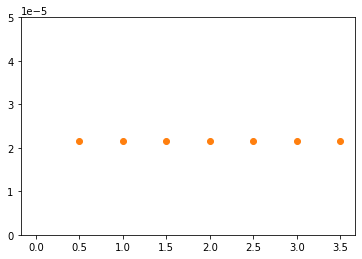

In [260]:
plt.scatter(pools,r1s)
plt.scatter(pools,r2s)
plt.ylim(ymin=0,ymax=.00005)
plt.show()

In [328]:
ecModel.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
CPD0-2167_c,DM_CPD0-2167_c,8.383E-07,5,100.00%
ADENINE_e,Exchange_ADENINE,9.595E-06,0,0.00%
ARG_e,Exchange_ARG,6.399E-06,0,0.00%
CA+2_e,Exchange_CA+2,1.126E-07,0,0.00%
CL-_e,Exchange_CL-,1.126E-07,0,0.00%
CPD-16459_e,Exchange_CPD-16459,1.943E-05,0,0.00%
FE+2_e,Exchange_FE+2,0.09715,0,0.00%
GLN_e,Exchange_GLN,1.839E-05,0,0.00%
GLT_e,Exchange_GLT,1.378,0,0.00%
Glucopyranose_e,Exchange_Glucopyranose,2.648E-05,0,0.00%


In [211]:
def prepare_omics_for_one_condition(dfomics,dftot,dfmws,condition_id,model):
    ''' 
    dfomics: a pandas.DataFrame that uses protein id as index and condition ids as coloumns, mmol/gdDW
    dftot  : a pandas.DataFrame that contains total protein abandance, gprotein/gDW
    dfmws  : a pandas.DataFrame that contains protein molecular weights, kDa
    model  : eModel
    
    
    Return 
    * non_measured, a list which contains a list of enzyme ids
    * measured, a dictionary with enzyme id as key and abandance as value
    * prot_pool, a value to define the total sum abandance of enzymes without proteomics
    * prot_pool was calculated as follows
        fracton_enzyme = tot_measured_enzyme/tot_measured_proteins
        tot_non_measured = Ptot-tot_measured_proteins
        prot_pool = tot_non_measured*fracton_enzyme
    
    Usage: measured, non_measured, prot_pool = prepare_omics_for_one_condition(dfomics,
    dftot,dfmws,condition_id,model)
    
    Gang Li
    20200806
    
    '''
    
    non_measured = []
    measured = {}
    
    assert condition_id in dfomics.columns
    for enz in model.enzymes:
        try: ab = dfomics.loc[enz,condition_id]
        except: ab = np.nan
        
        if np.isnan(ab): non_measured.append(enz)
        else: measured[enz] = ab
    
    tot_measured_proteins = np.sum([0 if np.isnan(dfomics.loc[ind,condition_id]) 
                                    else dfomics.loc[ind,condition_id]*dfmws.loc[ind,'MW'] 
                                    for ind in dfomics.index])
    
    tot_measured_enzymes  = np.sum([measured[ind]*dfmws.loc[ind,'MW'] for ind in measured.keys()])
    tot_non_measured      = dftot.loc[condition_id,'Ptot'] - tot_measured_proteins
    prot_pool = tot_non_measured*tot_measured_enzymes/tot_measured_proteins
    
    print('tot_proteins         :',dftot.loc[condition_id,'Ptot'])
    print('tot_measured_proteins:',tot_measured_proteins)
    print('tot_measured_enzymes :',tot_measured_enzymes)
    print('tot_non_measured     :',tot_non_measured)
    print('fracton_enzyme       :',tot_measured_enzymes/tot_measured_proteins)
    print('prot_pool            :',prot_pool)
    
    return measured, non_measured, prot_pool

In [ ]:
#basic Michaelis-Menten limited growth on glucose.
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.Exchange_Glucopyranose.lower_bound = glucose_max_import

def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['Biomass_v1', 'Exchange_Glucopyranose'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None

def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

In [ ]:
#add new biomass equation with PHA
model.reactions.Biomass_v1

